# Trainig a Model Using the MNIST datase for recgonise hand-writen digits
   
On this notebook we show how to create a model and train using  MNIST dataset for recognise handwritten digits.
We start showing how to read the bits from the dataset, then we do a quick introduction to neural network what 
is useful for understand the model thath we will train.
We start with a simple linear model, for then add convolutional and maxpooling layers.
At the end we use data augmentation and train for several epoch our model to try to get a high hit on the test data set.



# The Data

  We will start by understanding how the data is formatted and see hot we can parse it in a  suitable way for train our model.
  
  Mnist provide 4 files:
  
  -   training set images 
  -   training set labels
  -   test set images
  -   test set labels 
 
   [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/) 



## Little and Big Endian Architecture 

  There are 2 types of processors architecture(little and big endian). In little endian bits are store from left to right This is basically how the bytes are stored, in little they are stored from left to right and in big the other way around.(Look this is you want to know more about https://chortle.ccsu.edu/AssemblyTutorial/Chapter-15/ass15_3.html ).
  This is relevant for us because we need to know read the bytes right for get the proper data.
  
  In python we can easily check using sys, since I am using a Intel processor I expected to be little.


In [1]:
import numpy as np
from sys import byteorder

Now we can check  our architecture:

In [2]:
print(byteorder)

little


## Reading Mnist

  Now we can start reading the train images file. 
  From Mnist website we know what to expected from each bit read.


In [3]:
import gzip

with gzip.open('mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    fc_train_img = f.read()

  The first 4 bytes is the magic number which is a 32 bit integer, for the image set this number is 2051. Note that we are setting the byte order as big.

In [4]:
int.from_bytes(fc_train_img[0:4], byteorder='big')

2051

Next is the number of images as a 32 bit integer:

In [5]:
train_img_total = int.from_bytes(fc_train_img[4:8], byteorder='big')
train_img_total

60000

Then number of rows as 32 bit integer.

In [6]:
row = int.from_bytes(fc_train_img[8:12], byteorder='big')
row

28

And  columns  32 bit integer as well.

In [7]:
col = int.from_bytes(fc_train_img[12:16], byteorder='big')
col

28

Then all next are  unsigned bytes(8 bits) , each byte represent a pixel. They are organized row-wise.

The total of bits is: 
```python
train_img_total*row*col
```





In [8]:
last_byte = (train_img_total*row*col) + 16
last_byte

47040016

Now whe can read all bits:

In [9]:
x_train = list(fc_train_img[16:last_byte])

And reshape them ass 28*27 (784) array. That is the vector representation of the images.

In Mnist pixel values are 0 to 255.0 , 0 representing the background. We want to invert this, because having a non zero value as background is better for the training.

In [10]:
x_train = ~np.array(x_train).reshape(train_img_total,row*col).astype(np.uint8)
x_train.shape

(60000, 784)

We can see one image using pyplot:

In [11]:
import matplotlib.pyplot as plt
plt.imshow(x_train[11].reshape(row,col), cmap='gray')

Thats look like the image 11 is a 5. We can now read labels and check.

In [12]:
with gzip.open('mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    fc_train_lbl = f.read()

First 32 bits are the magic number : 2049

In [13]:
int.from_bytes(fc_train_lbl[0:4], byteorder='big')


2049

Then a 32 bits integer, the total of labels. Must be 6000 as we got 6000 images.

In [14]:
train_lvl_total = int.from_bytes(fc_train_lbl[4:8], byteorder='big')
train_lvl_total

60000

Now each unsigned byte is a label, so we can check that 11 is 5:

In [15]:
y_train = np.array(list(fc_train_lbl[8:train_lvl_total+8]))
print(y_train[11])

5


We now real the test images and labels:

In [16]:
with gzip.open('mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    fc_test_img = f.read()
with gzip.open('mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    fc_test_lbl = f.read()
    
test_img_total = int.from_bytes(fc_test_img[4:8], byteorder='big')
test_lbl_total = int.from_bytes(fc_test_lbl[4:8], byteorder='big')

last_byte = (test_img_total*row*col) + 16
x_test = list(fc_test_img[16:last_byte])
x_test = ~np.array(x_test).reshape(test_img_total,row*col).astype(np.uint8)

y_test = np.array(list(fc_test_lbl[8:test_lbl_total+8]))

In [17]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [18]:
x_train =  x_train/255.0
x_test = x_test/255.0

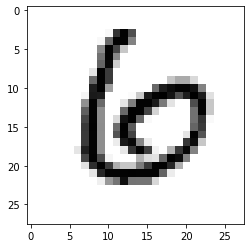

In [19]:
plt.imshow(x_test[11].reshape(row,col), cmap='gray')

In [20]:
print(y_test[11])

6


# Neuron Network

Most people can recognize handwrite digits with no problem(because we have a very complex brain). This is not a easy task for a computer. We will use the neural network approach, we will take a large number of labelled handwrite digits -the training examples- (x_train), and create a model that can learn from those examples.


## Neurons

The idea is simple, they take several inputs(  $ x_1, x_2 ... x_n $) and produce a single output.




![Single neuron](img/SingleNeuron.png)

Each input have  <i>weights</i>  $ w_1, w_2 ... w_n $ , a weight sum is calculated:${\sum_n x_n w_n}$ then the results goes through a activation function.

[http://neuralnetworksanddeeplearning.com/chap1.html](http://neuralnetworksanddeeplearning.com/chap1.html/) 

[https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb](https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/keras-neurons.ipynb) 



## Layers

We create layers composed of neurons. at least one input layer and a output layer is required, there can be hidden layers between the input and output layer. 

Our images are 28x28, we can create a 784 vector that represent the image. So we will feed out network with 784 inputs, this is our input layer that is also know as hidden layer.
Since we need to discriminate 10 numbers out output layer will have 10 neurons, each will represent a digit from 0 to 9. Then we can use SoftMax activation function for the output of each of our network to represent a probability of being a digit.


## Activation : softmax
   We want our result to represent a probability of being one of the 10 digits(0,1,3...).
  The SoftMax activation function will do this for us, it will output our output for each neuron between 0 and 1.Then each 
  of our neuron can represent a digit so the one will bigger probability will be our prediction.

  
  $$\sigma (z)_j = \frac{e^{(z)_j}}{\sum_{k=0}^{K}e^{(z)_k}} \text{  where   j = 1,...,K}$$  
  
  In our case K = 10.
  
  https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/

## First model

 We will start create a 2 layers model, input and output : the input layer will be the 784 vector created with the image data and the output a 10 neuros with activation SoftMax. 
 

![Single neuron](img/Model1.png)

We will use keras and TensorFlow

In [21]:
import keras as kr

Using TensorFlow backend.


In [22]:
# create sequeantial model
model = kr.models.Sequential()

# The input layer is added by keras when we set input = 784 
# We add 10 neuroas with softmax for output
model.add(kr.layers.Dense(units=10, input_dim=784, activation='softmax'))

# Compile the model.
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

We can se a summary of our model:

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


The 7850 parameters are:
 10 weights from each input node to each output made 7840 plus 10 weights on the outputs nodes.


We are missing few thinks to explain: loss, optimizer and metrics.

## Loss : categorical_crossentropy


 This is how we measure how well our algorithm model the dataset. 
   
 Categorical cross entropy is used when only one value can belong to each class (our 10 outputs), so just what we need for measure our model because we are looking for predicted one number. Our output should be the number prediction.

   
   [https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy)
   
   
  [https://algorithmia.com/blog/introduction-to-loss-functions](https://algorithmia.com/blog/introduction-to-loss-functions)
    

## Optimazer : adam

When we are training our model the weights are change acordally for make our prediction better. How much and how are they change is the job of the optimizer, is the optimizer who shape our model for a correct prediction.

Adaptative moment estimation(ADAM) use gradient decent. This is how it work([literally taked from Algorithmia](https://algorithmia.com/blog/introduction-to-optimizers)  )


1) Calculate what a small change in each individual weight would do to the loss function (i.e. which direction should the hiker walk in)

2) Adjust each individual weight based on its gradient (i.e. take a small step in the determined direction)

3) Keep doing steps #1 and #2 until the loss function gets as low as possible



Adam use pas gradients to calculate current gradients and also utilizes the concept of [momentun](https://ruder.io/optimizing-gradient-descent/index.html#momentum).


[https://keras.io/optimizers/](https://keras.io/optimizers/)


[https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html](https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html)


[https://https://algorithmia.com/blog/introduction-to-optimizers.com/blog/introduction-to-optimizers](https://https://algorithmia.com/blog/introduction-to-optimizers.com/blog/introduction-to-optimizers)

## Preparing the labes
    
We are almost done for train our model for first time, the only problems is that our labels are a single digit. We need make them vectors with a 1 on the number position.

In [24]:
y_train = kr.utils.to_categorical(y_train, 10)
y_test  = kr.utils.to_categorical(y_test, 10)

In [25]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

Now we are ready, we will start training this simple model with 10 epochs, batch of 100 (means we train the model with 100 images at a time).

In [26]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.7960 - accuracy: 0.7913 - val_loss: 0.4495 - val_accuracy: 0.8787
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.4266 - accuracy: 0.8804 - val_loss: 0.3650 - val_accuracy: 0.8991
Epoch 3/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3763 - accuracy: 0.8921 - val_loss: 0.3453 - val_accuracy: 0.9007
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3538 - accuracy: 0.8979 - val_loss: 0.3477 - val_accuracy: 0.8978
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3398 - accuracy: 0.9010 - val_loss: 0.3213 - val_accuracy: 0.9035
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3303 - accuracy: 0.9046 - val_loss: 0.3160 - val_accuracy: 0.9083
Epoch 7/10
60000/60000 [==============================] - 1s 21us/st

## First results

We have achieved a 99.67 accuracy with this very simple model, this is going to be our baseline and we change our model for improve the results.

We can get data history, since we will be doing this several times I also define a function for use later.

In [27]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

Blue is test accuracy on training set and red is the accuracy on the test set. We want to improve red.

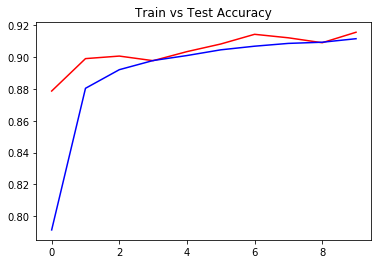

In [28]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

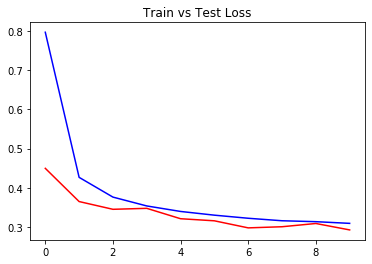

In [29]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

We got to 89% accuracy with just 10 simple neurons, this is our output layer and we can of course improve our model.

# Adding more Layers and Relu activation function

# Relu

Rectified linear unit(Relu), is one of the most common activation functions in neural networks. Relu is very simple, linear for all positive values and 0 for all negative values:
$$ f(x)       \begin{cases}
       \text{0,} &\quad\text{if } x \le0\\
       f(x) &\quad\text{if } x  >0 \\
       \end{cases}$$


![Relu](img/relu.png)

# Some advantages of Relu:
- Cheap to compute.
- Good sparsity.
- Converge faster.

[https://keras.io/activations/](https://keras.io/activations/)

[https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7) 

[https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general](https://datascience.stackexchange.com/questions/14349/difference-of-activation-functions-in-neural-networks-in-general)

## Extra layers

We can now add more layers using Relu activation function:
- Same input layer.
- Hidden layers  512 and 98 neurons, with Relu.
- Same output layer, 10 neurons with SoftMax.

In [30]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_3 (Dense)              (None, 98)                50274     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [32]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.5582 - accuracy: 0.8306 - val_loss: 0.3202 - val_accuracy: 0.9074
Epoch 2/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2952 - accuracy: 0.9110 - val_loss: 0.2701 - val_accuracy: 0.9198
Epoch 3/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2320 - accuracy: 0.9299 - val_loss: 0.1794 - val_accuracy: 0.9470
Epoch 4/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1857 - accuracy: 0.9428 - val_loss: 0.1647 - val_accuracy: 0.9507
Epoch 5/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1649 - accuracy: 0.9492 - val_loss: 0.1398 - val_accuracy: 0.9576
Epoch 6/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.1434 - accuracy: 0.9553 - val_loss: 0.1574 - val_accuracy: 0.9487
Epoch 7/10
60000/60000 [==============================] - 2s 28us/st

In [33]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

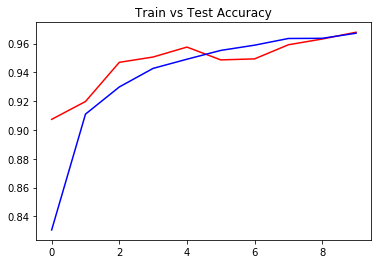

In [34]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

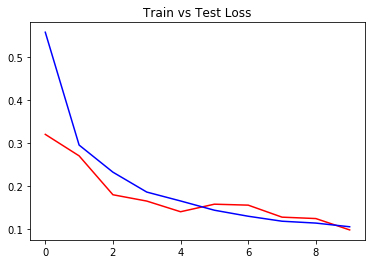

In [35]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

Relu and the extra layers have give a great improvement to our model, from 89% to 96%.

# Dropout

Drop out is regularization technic, basically we drop some random neurons during training, 
they are temporary shutted down. 

Is believe that this make other neurons be more active so improve the learning rate.

The effect is a network that is less sensitive to specific weights of neurons. The network is capable of a better generalization and avoid overfit.

Drop out is very easily implemented with Keras, we just need to pick a percent of dropped out neurons for each epoch.


[https://keras.io/layers/core/](https://keras.io/layers/core/)

[https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)

In [36]:
model = kr.models.Sequential()
model.add(kr.layers.Dense(units=512, input_dim=784, activation='relu'))
model.add(kr.layers.Dropout(0.01))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 98)                50274     
_________________________________________________________________
dropout_2 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                990       
Total params: 453,184
Trainable params: 453,184
Non-trainable params: 0
_________________________________________________________________


In [38]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.6149 - accuracy: 0.8094 - val_loss: 0.3248 - val_accuracy: 0.9016
Epoch 2/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.3152 - accuracy: 0.9020 - val_loss: 0.2211 - val_accuracy: 0.9328
Epoch 3/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.2399 - accuracy: 0.9263 - val_loss: 0.1863 - val_accuracy: 0.9411
Epoch 4/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.2069 - accuracy: 0.9369 - val_loss: 0.1629 - val_accuracy: 0.9501
Epoch 5/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.1812 - accuracy: 0.9430 - val_loss: 0.1525 - val_accuracy: 0.9509
Epoch 6/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.1638 - accuracy: 0.9493 - val_loss: 0.1239 - val_accuracy: 0.9619
Epoch 7/10
60000/60000 [==============================] - 2s 31us/st

In [39]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

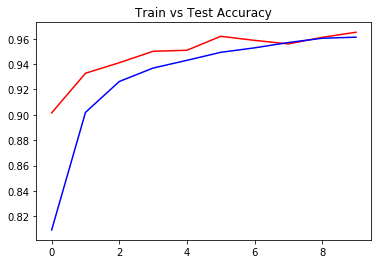

In [40]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

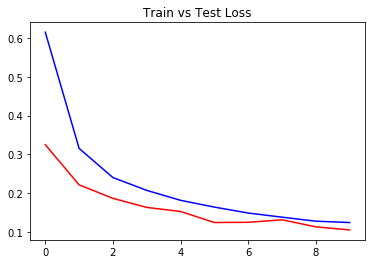

In [41]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

Dropout improve our model from 96% to 96.5%, litle improvement but relevant.

# 2D Convolutional Neural Network

We have achieve 97% accuracy on our model, but we are missing a very important point : shapes are 2D images and there is a relation between pixels. Transforming our image in a 1D vector we completely ignore the shape of the image.
Using convolutional neurons we can feed neurons with 2D arrays of pixels and someone preserve the data on the shape of the image.

In the image bellow we can see how a 3x3 convolutional networks works. Note that the image is just for illustrate how convolutional networks works, is not related with the one we will use.


![Conv2d](img/conv2d.gif)

### image from:  [https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)

[https://keras.io/layers/convolutional/](https://keras.io/layers/convolutional/)

[https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

## Reforating input data for convolutional network

We now need to reshape our data for be a 28 by 28 array so it can be fit onto the convolutional network.

In [42]:
x_train = x_train.reshape(train_img_total,col,row,1)
x_test = x_test.reshape(test_img_total,col,row,1)

In [43]:
x_train.shape

(60000, 28, 28, 1)

In [44]:
model = kr.models.Sequential()

model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [45]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 223us/step - loss: 0.3743 - accuracy: 0.8954 - val_loss: 0.0923 - val_accuracy: 0.9719
Epoch 2/10
60000/60000 [==============================] - 12s 197us/step - loss: 0.0962 - accuracy: 0.9719 - val_loss: 0.0632 - val_accuracy: 0.9807
Epoch 3/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.0651 - accuracy: 0.9799 - val_loss: 0.0596 - val_accuracy: 0.9823
Epoch 4/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.0468 - accuracy: 0.9849 - val_loss: 0.0555 - val_accuracy: 0.9839
Epoch 5/10
60000/60000 [==============================] - 12s 197us/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0573 - val_accuracy: 0.9818
Epoch 6/10
60000/60000 [==============================] - 12s 196us/step - loss: 0.0303 - accuracy: 0.9898 - val_loss: 0.0584 - val_accuracy: 0.9837
Epoch 7/10
60000/60000 [==============================] 

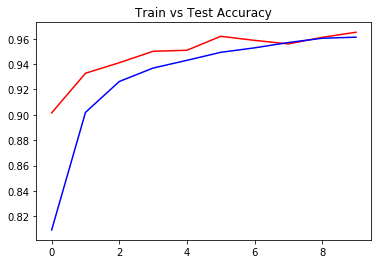

In [46]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

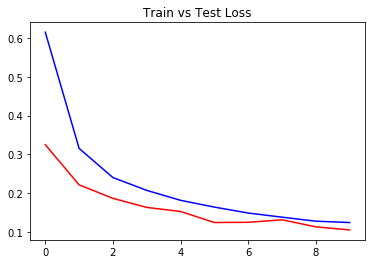

In [47]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

With just 1 convolutional layer we have improve our accuracy to 98%. Great improvement but there is still place for more...

## More layers and max polling

A polling layer is a layer that we add after a convolutional layer.  The polling layer will operate over each pixel for create a new set of pulled data. We will use max polling of size 2x2 pixels. This means that the maximum of each 2x2 patch will be calculated.

### Benefits:

- Model invariance to local translation.
- Faster computations.



![MAxPolling2d](img/maxpolling2d.png)

image from: [https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/](https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/)

[https://keras.io/layers/pooling/](https://keras.io/layers/pooling/)

[https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)

In [48]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [49]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.2291 - accuracy: 0.9247 - val_loss: 0.0981 - val_accuracy: 0.9697
Epoch 2/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.0624 - accuracy: 0.9817 - val_loss: 0.0329 - val_accuracy: 0.9896
Epoch 3/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.0326 - val_accuracy: 0.9896
Epoch 4/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0345 - accuracy: 0.9901 - val_loss: 0.0346 - val_accuracy: 0.9908
Epoch 5/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0321 - accuracy: 0.9906 - val_loss: 0.0331 - val_accuracy: 0.9914
Epoch 6/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0251 - accuracy: 0.9929 - val_loss: 0.0281 - val_accuracy: 0.9918
Epoch 7/10
60000/60000 [==============================] - 5s 88us/st

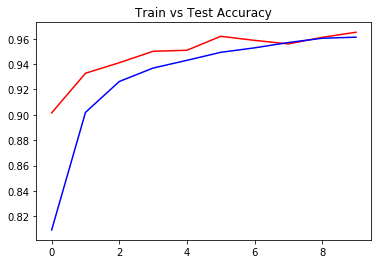

In [50]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

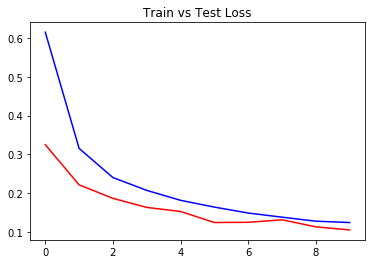

In [51]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

Great improvement , we are at 99.5% now. 



## Batch normalization

## Batch Normalization


We can normalize beetwen layers for speed up training. Normalization function will keep values at same range, mean that we will not have very high values.

Some advatages:

- Layers can learn  a bit more independently.
- Allow higher rate of leanrning.
- Reduce overfit.

https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

https://arxiv.org/pdf/1502.03167v2.pdf

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
    

In [52]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Flatten())
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Dense(units=98, activation='relu'))
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [53]:
epoch = 10
history_callback = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epoch, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.2119 - accuracy: 0.9313 - val_loss: 0.0610 - val_accuracy: 0.9817
Epoch 2/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0590 - accuracy: 0.9835 - val_loss: 0.0335 - val_accuracy: 0.9895
Epoch 3/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0443 - accuracy: 0.9873 - val_loss: 0.0354 - val_accuracy: 0.9896
Epoch 4/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0339 - accuracy: 0.9899 - val_loss: 0.0523 - val_accuracy: 0.9861
Epoch 5/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0302 - accuracy: 0.9912 - val_loss: 0.0317 - val_accuracy: 0.9909
Epoch 6/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.0277 - accuracy: 0.9923 - val_loss: 0.0291 - val_accuracy: 0.9913
Epoch 7/10
60000/60000 [==============================] - 5s 86us/st

In [54]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])

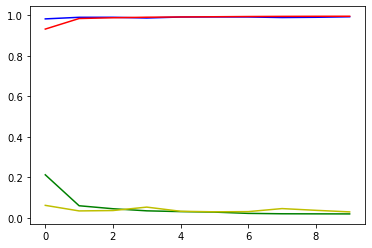

In [55]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'b',x,accuracy,'r',x,loss,'g',x,val_loss,'y')

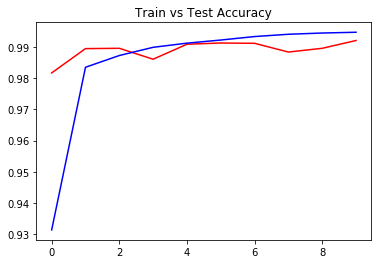

In [56]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

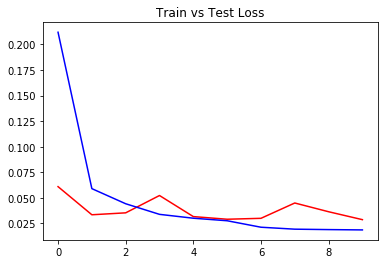

In [57]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

# Final Model

![Final Model](img/finalmodel.png)

* image created using : [NN-SVG](http://alexlenail.me/NN-SVG/LeNet.html)


In [58]:
model = kr.models.Sequential()
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu',input_shape=(28,28,1)))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(7, 7),activation='relu'))
kr.layers.normalization.BatchNormalization(axis=-1)
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Conv2D(128,kernel_size=(5, 5),activation='relu'))
model.add(kr.layers.Dropout(0.01))
model.add(kr.layers.Conv2D(256,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))
model.add(kr.layers.Dropout(0.25))
model.add(kr.layers.Flatten())
kr.layers.normalization.BatchNormalization()
model.add(kr.layers.Dense(units=128, activation='relu'))
model.add(kr.layers.Dense(units=10, activation='softmax'))
model.compile(loss=kr.losses.categorical_crossentropy,optimizer='adadelta',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 22, 22, 64)        3200      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        200768    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)         204928    
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 256)        

# Data Augmentation Image Generator

We we able to reach  maximun of 99.5% on our test data. Could be great if we can have more data for train the model, the great news are that we can generate more data and keras has librarys that do it for us...


https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced


In [59]:
from keras.preprocessing.image import ImageDataGenerator

We just need to set parameters of our image generator generate images with litle variations.

In [60]:
#modified from https://github.com/yashk2810/MNIST-Keras/blob/master/Notebook/MNIST_keras_CNN-99.55%25.ipynb
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

In [61]:
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_test, y_test, batch_size=64)

Code below will generate a batch of 64 images in x1 and 64 labels in y1

In [62]:
x1,y1 = train_generator.next()

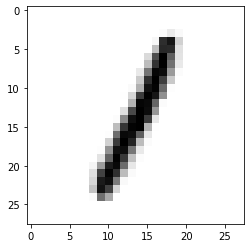

In [63]:
plt.imshow(x1[3].reshape(28,28), cmap='gray')

In [64]:
y1[3]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

They look very similar but this will give a great improvement to our model performance...

In [65]:
epoch =10
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/10
937/937 [==============================] - 10s 10ms/step - loss: 0.3499 - accuracy: 0.8871 - val_loss: 0.0381 - val_accuracy: 0.9850
Epoch 2/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0801 - accuracy: 0.9768 - val_loss: 0.0848 - val_accuracy: 0.9909
Epoch 3/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0570 - accuracy: 0.9840 - val_loss: 0.0022 - val_accuracy: 0.9909
Epoch 4/10
937/937 [==============================] - 9s 10ms/step - loss: 0.0483 - accuracy: 0.9862 - val_loss: 0.0046 - val_accuracy: 0.9941
Epoch 5/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0416 - accuracy: 0.9883 - val_loss: 6.3042e-04 - val_accuracy: 0.9938
Epoch 6/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0390 - accuracy: 0.9892 - val_loss: 4.2203e-04 - val_accuracy: 0.9945
Epoch 7/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0347 - accuracy: 0.9903 - val_loss: 0.0380 - val_acc

In [66]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


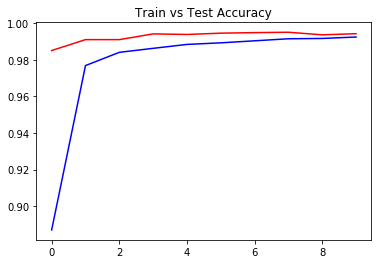

In [67]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Accuracy')
plt.plot(x,val_accuracy,'r',x,accuracy,'b')

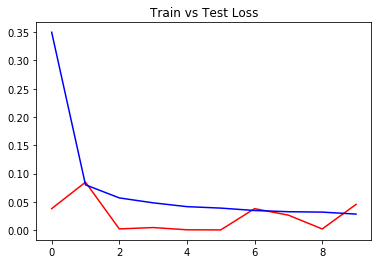

In [68]:
x = np.arange(0.0, epoch, 1)
plt.title('Train vs Test Loss')
plt.plot(x,val_loss,'r',x,loss,'b')

# Looking for high hit

As we want a static model with high accuracy on the original Mnist train set. We can notice that the accuracy vary from epoch going up and down, also there is a little variation on the accuracy on the original train set and the generated train set. So we will add a call back function that check accuracy against original test set after each epoch, then if the accuracy is higher than the minimum or the last high model we save the model.

In this way we are looking for a "lucky" hit.

## Custom Checkpoint


In [69]:
test_acc =[]

In [70]:
# code medified from https://www.tensorflow.org/guide/keras/custom_callback
class CustomModelCheckpoint(kr.callbacks.Callback):
    minimun = 0.995
    def on_epoch_end(self, epoch, logs=None):
        # calculate accuracy again original test set
        score = self.model.evaluate(x_test, y_test, verbose=0)
        print(score[1])
        test_acc.append(score[1])
        if score[1] > self.minimun: # your custom conditio
            #save the model if is higher
            self.model.save('static/model.h5', overwrite=True)
            self.minimun = score[1]
            # print the real acurracy
            print("*******************************************************************************************************")
            print(self.minimun)
            print("*******************************************************************************************************")

In [71]:
cbk = CustomModelCheckpoint()

In [72]:
epoch =700
history_callback= model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64, callbacks=[cbk])

Epoch 1/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0257 - accuracy: 0.9927 - val_loss: 1.5349e-04 - val_accuracy: 0.9942
0.9941999912261963
Epoch 2/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0264 - accuracy: 0.9928 - val_loss: 3.3959e-05 - val_accuracy: 0.9936
0.9936000108718872
Epoch 3/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0071 - val_accuracy: 0.9937
0.9937999844551086
Epoch 4/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0227 - accuracy: 0.9938 - val_loss: 0.0265 - val_accuracy: 0.9932
0.9932000041007996
Epoch 5/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0219 - accuracy: 0.9940 - val_loss: 4.6882e-06 - val_accuracy: 0.9953
0.995199978351593
*******************************************************************************************************
0.995199978351593
*************************************************

0.994700014591217
Epoch 45/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0153 - accuracy: 0.9965 - val_loss: 1.4342e-07 - val_accuracy: 0.9952
0.9955000281333923
Epoch 46/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0692 - val_accuracy: 0.9960
0.9961000084877014
Epoch 47/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0130 - accuracy: 0.9971 - val_loss: 1.3597e-07 - val_accuracy: 0.9951
0.9947999715805054
Epoch 48/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 9.8700e-05 - val_accuracy: 0.9943
0.9950000047683716
Epoch 49/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0136 - accuracy: 0.9969 - val_loss: 0.1341 - val_accuracy: 0.9951
0.995199978351593
Epoch 50/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0118 - accuracy: 0.9971 - val_loss: 1.8574e-05 - val_accuracy: 0.9948

937/937 [==============================] - 9s 10ms/step - loss: 0.0118 - accuracy: 0.9978 - val_loss: 0.0053 - val_accuracy: 0.9958
0.9955999851226807
Epoch 93/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0131 - accuracy: 0.9973 - val_loss: 1.6764e-08 - val_accuracy: 0.9952
0.9951000213623047
Epoch 94/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0126 - accuracy: 0.9976 - val_loss: 3.7253e-09 - val_accuracy: 0.9957
0.9954000115394592
Epoch 95/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0109 - accuracy: 0.9977 - val_loss: 7.0780e-08 - val_accuracy: 0.9952
0.995199978351593
Epoch 96/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0086 - accuracy: 0.9982 - val_loss: 0.0000e+00 - val_accuracy: 0.9957
0.9950000047683716
Epoch 97/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0105 - accuracy: 0.9977 - val_loss: 1.6763e-06 - val_accuracy: 0.9954
0.9952999949455261
Epoch 

937/937 [==============================] - 10s 10ms/step - loss: 0.0113 - accuracy: 0.9976 - val_loss: 0.0790 - val_accuracy: 0.9952
0.994700014591217
Epoch 140/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0130 - accuracy: 0.9976 - val_loss: 2.5704e-07 - val_accuracy: 0.9952
0.9948999881744385
Epoch 141/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.0000e+00 - val_accuracy: 0.9955
0.9952999949455261
Epoch 142/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 0.0962 - val_accuracy: 0.9950
0.9951000213623047
Epoch 143/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.0532 - val_accuracy: 0.9956
0.995199978351593
Epoch 144/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0092 - accuracy: 0.9982 - val_loss: 1.4342e-06 - val_accuracy: 0.9951
0.9952999949455261
Epoch 145/

937/937 [==============================] - 10s 11ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.0000e+00 - val_accuracy: 0.9962
0.9962000250816345
Epoch 189/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0115 - accuracy: 0.9978 - val_loss: 0.0000e+00 - val_accuracy: 0.9954
0.9952999949455261
Epoch 190/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0086 - accuracy: 0.9983 - val_loss: 2.0581e-06 - val_accuracy: 0.9953
0.9954000115394592
Epoch 191/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0089 - accuracy: 0.9983 - val_loss: 0.6333 - val_accuracy: 0.9962
0.9955000281333923
Epoch 192/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0101 - accuracy: 0.9984 - val_loss: 0.0000e+00 - val_accuracy: 0.9962
0.9961000084877014
Epoch 193/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0095 - accuracy: 0.9983 - val_loss: 0.2097 - val_accuracy: 0.9946
0.9951000213623047
Ep

0.9957000017166138
Epoch 237/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.0014 - val_accuracy: 0.9962
0.9957000017166138
Epoch 238/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0107 - accuracy: 0.9984 - val_loss: 7.7214e-06 - val_accuracy: 0.9951
0.9944999814033508
Epoch 239/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0102 - accuracy: 0.9984 - val_loss: 0.0198 - val_accuracy: 0.9963
0.9958999752998352
Epoch 240/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.0000e+00 - val_accuracy: 0.9954
0.9958000183105469
Epoch 241/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0111 - accuracy: 0.9982 - val_loss: 0.0000e+00 - val_accuracy: 0.9949
0.995199978351593
Epoch 242/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.0069 - val_accuracy: 0.9

0.9954000115394592
Epoch 286/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0097 - accuracy: 0.9985 - val_loss: 0.0000e+00 - val_accuracy: 0.9950
0.995199978351593
Epoch 287/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0110 - accuracy: 0.9982 - val_loss: 3.8049e-06 - val_accuracy: 0.9950
0.9950000047683716
Epoch 288/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0101 - accuracy: 0.9983 - val_loss: 0.0000e+00 - val_accuracy: 0.9954
0.9950000047683716
Epoch 289/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 3.6800e-05 - val_accuracy: 0.9952
0.9957000017166138
Epoch 290/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0135 - accuracy: 0.9977 - val_loss: 5.5685e-04 - val_accuracy: 0.9968
0.9965000152587891
Epoch 291/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.0000e+00 - val

937/937 [==============================] - 10s 10ms/step - loss: 0.0092 - accuracy: 0.9983 - val_loss: 2.5747e-05 - val_accuracy: 0.9947
0.9950000047683716
Epoch 335/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0119 - accuracy: 0.9982 - val_loss: 2.2538e-07 - val_accuracy: 0.9955
0.9955000281333923
Epoch 336/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0111 - accuracy: 0.9983 - val_loss: 1.1735e-07 - val_accuracy: 0.9962
0.9955999851226807
Epoch 337/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0098 - accuracy: 0.9984 - val_loss: 0.0000e+00 - val_accuracy: 0.9956
0.9957000017166138
Epoch 338/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 6.2956e-07 - val_accuracy: 0.9953
0.9951000213623047
Epoch 339/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0098 - accuracy: 0.9985 - val_loss: 0.0000e+00 - val_accuracy: 0.9955
0.9955999851226

0.9958000183105469
Epoch 383/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0115 - accuracy: 0.9984 - val_loss: 0.0000e+00 - val_accuracy: 0.9960
0.9955999851226807
Epoch 384/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 0.3350 - val_accuracy: 0.9956
0.9952999949455261
Epoch 385/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.9941
0.9947999715805054
Epoch 386/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0102 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9947
0.9948999881744385
Epoch 387/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0118 - accuracy: 0.9982 - val_loss: 1.3039e-08 - val_accuracy: 0.9953
0.9954000115394592
Epoch 388/700
937/937 [==============================] - 11s 11ms/step - loss: 0.0086 - accuracy: 0.9985 - val_loss: 3.3714e-07 - val_a

937/937 [==============================] - 10s 11ms/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 0.0000e+00 - val_accuracy: 0.9959
0.9958999752998352
Epoch 432/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0066 - accuracy: 0.9989 - val_loss: 0.0726 - val_accuracy: 0.9960
0.9959999918937683
Epoch 433/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0098 - accuracy: 0.9987 - val_loss: 0.0447 - val_accuracy: 0.9948
0.9957000017166138
Epoch 434/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9958
0.9955999851226807
Epoch 435/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 9.4995e-08 - val_accuracy: 0.9958
0.9955000281333923
Epoch 436/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0091 - accuracy: 0.9987 - val_loss: 2.4762e-04 - val_accuracy: 0.9957
0.9958999752998352
Ep

0.9958000183105469
Epoch 480/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0095 - accuracy: 0.9989 - val_loss: 3.0377e-06 - val_accuracy: 0.9957
0.9954000115394592
Epoch 481/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0082 - accuracy: 0.9988 - val_loss: 1.0245e-07 - val_accuracy: 0.9955
0.9955000281333923
Epoch 482/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9961
0.9958999752998352
Epoch 483/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.0207 - val_accuracy: 0.9956
0.9957000017166138
Epoch 484/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.9954
0.9954000115394592
Epoch 485/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0628 - val_accura

937/937 [==============================] - 10s 11ms/step - loss: 0.0089 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9959
0.9957000017166138
Epoch 529/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0093 - accuracy: 0.9988 - val_loss: 9.7195e-05 - val_accuracy: 0.9961
0.9957000017166138
Epoch 530/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0102 - accuracy: 0.9988 - val_loss: 2.7192e-06 - val_accuracy: 0.9954
0.995199978351593
Epoch 531/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0119 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9942
0.9950000047683716
Epoch 532/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.3115 - val_accuracy: 0.9943
0.9944999814033508
Epoch 533/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0074 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.9953
0.9959999918937683
E

0.9955000281333923
Epoch 577/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0089 - accuracy: 0.9988 - val_loss: 0.0040 - val_accuracy: 0.9952
0.9958999752998352
Epoch 578/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.9957
0.9954000115394592
Epoch 579/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9961
0.9955000281333923
Epoch 580/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 9.7722e-04 - val_accuracy: 0.9960
0.9958000183105469
Epoch 581/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0102 - accuracy: 0.9987 - val_loss: 0.0000e+00 - val_accuracy: 0.9960
0.9961000084877014
Epoch 582/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 3.7253e-09 - val_acc

937/937 [==============================] - 10s 11ms/step - loss: 0.0144 - accuracy: 0.9987 - val_loss: 0.1265 - val_accuracy: 0.9949
0.9950000047683716
Epoch 626/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0094 - accuracy: 0.9990 - val_loss: 1.5318 - val_accuracy: 0.9954
0.9955000281333923
Epoch 627/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0093 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 0.9957
0.9955999851226807
Epoch 628/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0086 - accuracy: 0.9990 - val_loss: 0.0239 - val_accuracy: 0.9964
0.996399998664856
Epoch 629/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0107 - accuracy: 0.9988 - val_loss: 0.0444 - val_accuracy: 0.9947
0.994700014591217
Epoch 630/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0124 - accuracy: 0.9988 - val_loss: 9.3132e-09 - val_accuracy: 0.9950
0.9950000047683716
Epoch 631/700
9

0.9965999722480774
Epoch 674/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0098 - accuracy: 0.9990 - val_loss: 3.4401e-06 - val_accuracy: 0.9961
0.9954000115394592
Epoch 675/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0090 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9959
0.9958000183105469
Epoch 676/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0105 - accuracy: 0.9991 - val_loss: 1.7843e-06 - val_accuracy: 0.9955
0.9951000213623047
Epoch 677/700
937/937 [==============================] - 10s 10ms/step - loss: 0.0086 - accuracy: 0.9990 - val_loss: 0.0000e+00 - val_accuracy: 0.9964
0.9966999888420105
Epoch 678/700
937/937 [==============================] - 10s 11ms/step - loss: 0.0096 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 0.9962
0.9962999820709229
Epoch 679/700
937/937 [==============================] - 9s 10ms/step - loss: 0.0070 - accuracy: 0.9991 - val_loss: 2.1813e-04 - val

In [73]:
val_accuracy = np.array(history_callback.history['val_accuracy'])
val_loss =  np.array(history_callback.history['val_loss'])
accuracy =  np.array(history_callback.history['accuracy'])
loss =  np.array(history_callback.history['loss'])


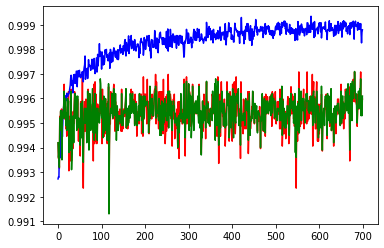

In [74]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,val_accuracy,'r',x,accuracy,'b',test_acc,'g')

In [75]:
loss[92]

0.013091701849016516

In [76]:
score = kr.models.load_model('./static/model.h5').evaluate(x_test, y_test, verbose=0)
score

[0.06513460730101481, 0.9970999956130981]

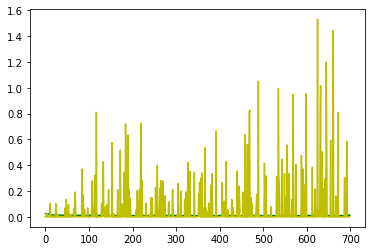

In [77]:
x = np.arange(0.0, epoch, 1)
plt.plot(x,loss,'g',x,val_loss,'y')